In [1]:
# Load modules
%pylab inline
from netCDF4 import Dataset # to work with NetCDF files
import numpy as np
import matplotlib.pyplot as plt # to generate plots
from mpl_toolkits.basemap import Basemap # plot on map projections
from os.path import expanduser
home = expanduser("~") # Get users home directory
import os # operating system interface
import scipy as sp
import xarray as xr
from xarray.ufuncs import square, sqrt
import scipy.interpolate
import scipy.ndimage

Populating the interactive namespace from numpy and matplotlib


In [2]:
%matplotlib inline
from parcels import FieldSet, ParticleSet, Variable, JITParticle, AdvectionRK4, plotTrajectoriesFile, ParticleFile
import numpy as np
import math
from datetime import timedelta

In [3]:
filenames = "/g/data3/hh5/tmp/pas561/gfdl_nyf_1080_PI_Ant_20Eto140E/5yrs_5day/IC200/output201/ocean__201_00*.nc"
variables = {'U': 'u',
             'V': 'v',
             'W': 'wt',
            'temp': 'temp'}
dimensions = {'lat': 'geolat_t',
              'lon': 'geolon_t',
              'depth':'st_ocean',
              'time': 'time'}
fieldset = FieldSet.from_netcdf(filenames, variables, dimensions,allow_time_extrapolation=True)
fieldset.add_periodic_halo(zonal=True,meridional=False,halosize=2)

/g/data3/hh5/public/apps/miniconda3/envs/analysis27-18.10/lib/python2.7/site-packages/xarray/coding/times.py:132: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy cftime.datetime objects instead, reason: dates out of range
  enable_cftimeindex)
/g/data3/hh5/public/apps/miniconda3/envs/analysis27-18.10/lib/python2.7/site-packages/xarray/coding/variables.py:69: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy cftime.datetime objects instead, reason: dates out of range
  return self.func(self.array)


In [ ]:
print fieldset.U.__dict__

In [4]:
class tempparticle(JITParticle):
    temp=Variable('temp',initial=fieldset.temp)

In [5]:
lons,lats,depths=np.meshgrid(np.arange(-10,10,2),np.arange(-65,-60,2),np.arange(10,5000,500))
print lons.shape
#time=-1 to go backwards
pset=ParticleSet(fieldset,tempparticle,lons,lats,depth=depths,time=fieldset.U.grid.time_full[0])

(3, 10, 10)


/g/data3/hh5/public/apps/miniconda3/envs/analysis27-18.10/lib/python2.7/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/110m/physical/ne_110m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


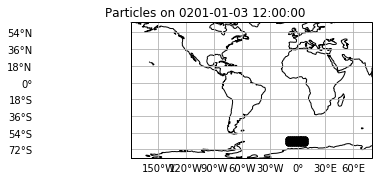

In [6]:
pset.show()

In [7]:
print fieldset.U.grid.lon

[-280.375 -280.125 -279.875 ...   79.875   80.125   80.375]


In [8]:
def periodicbc(particle, fieldset, time, dt):
    if particle.lon >= 80:
        particle.lon -= 360
    if particle.lon <= -280:
        particle.lon += 360
        
def sampletemp(particle, fieldset, time, dt):
    particle.temp = fieldset.temp[time,particle.lon,particle.lat,particle.depth]

In [9]:
pfile=pset.ParticleFile('myfirstparcels',outputdt=86400)

In [10]:
pset.execute(pset.Kernel(periodicbc)+AdvectionRK4+sampletemp,dt=3600,runtime=86400*365,output_file=pfile)

INFO: Compiled tempparticleperiodicbcAdvectionRK4sampletemp ==> /local/e14/pas561/tmp/parcels-5564/8278b0b9540ad2f42781fc7fae0c75b9.so
100% (31536000.0 of 31536000.0) |########| Elapsed Time: 0:03:10 Time:  0:03:10


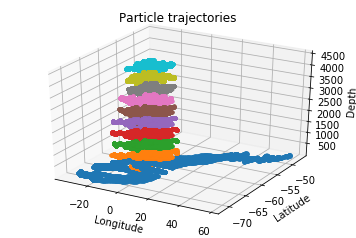

<module 'matplotlib.pyplot' from '/g/data3/hh5/public/apps/miniconda3/envs/analysis27-18.10/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

In [11]:
plotTrajectoriesFile('myfirstparcels.nc',mode='3d')